Universidad del Valle de Guatemala

Facultad de Ingeniería

Departamento de Ciencias de la Computación

CC3084 – Data Science

# Laboratorio 5
## Clasificación de tweets usando minería de texto

Daniel Valdez - 21240

Emilio Solano - 21212

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer



### Carga y descripción de datos


#### Evaluación del dataset

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


#### Verificar y tratar valores nulos

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


<Axes: >

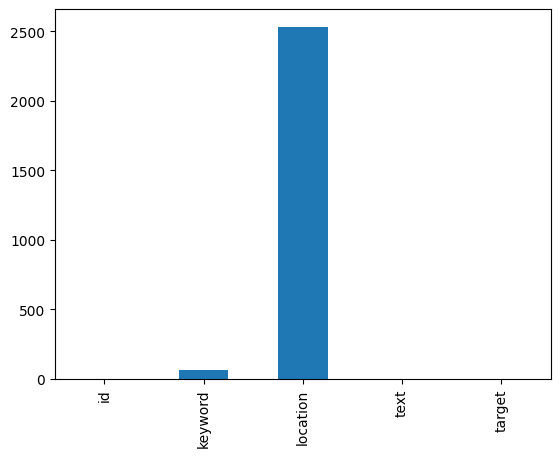

In [6]:
print(df.isnull().sum())
# Show into a graph how percentage of missing values in each column
df.isnull().sum().plot(kind='bar')

In [5]:
df['keyword'].fillna('', inplace=True)
df['location'].fillna('Unknown', inplace=True)

In [8]:
df.head()

,id,keyword,location,text,target
0,1,,Unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,,Unknown,Forest fire near La Ronge Sask. Canada,1
2,5,,Unknown,All residents asked to 'shelter in place' are ...,1
3,6,,Unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,,Unknown,Just got sent this photo from Ruby #Alaska as ...,1


### Preprocesamiento de datos

#### Limpieza

In [6]:
# Descargar stopwords si no están disponibles
nltk.download('stopwords')

# Convertir a minúsculas
df['cleaned_text'] = df['text'].str.lower()

# Eliminar URLs
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'http\S+', '', x))

# Eliminar menciones, hashtags, caracteres especiales y números
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'@\w+|#\w+|\W|\d+', ' ', x))

# Eliminar stopwords
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Intentamos verificar el sentimiento del mensaje, esto puede ser util cuando se tratan de desastres.

Y aunque segun el diagrama de caja y bigotes no es tan optimo como esperabamos. Igual muestra ciertas irregularidades. Como que en los desastres el sentimiento casi siempre es cercano a 0.

Esto puede ser bastante util para la prediccion del modelo en cuestion.

In [7]:
from textblob import TextBlob

# Función para obtener el sentimiento
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    # Convert polaity on a float into the range 1.0  and 0.0
    sentiment = (polarity + 1) / 2
    return sentiment

# Aplicar la función a los tweets
df['sentiment'] = df['cleaned_text'].apply(get_sentiment)
df.head(10)

,id,keyword,location,text,target,cleaned_text,sentiment
0,1,,Unknown,Our Deeds are the Reason of this #earthquake M...,1,deeds reason may allah forgive us,0.50000
1,4,,Unknown,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,0.55000
2,5,,Unknown,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,0.45000
3,6,,Unknown,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders california,0.50000
4,7,,Unknown,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,0.50000
5,8,,Unknown,#RockyFire Update => California Hwy. 20 closed...,1,update california hwy closed directions due la...,0.44375
6,10,,Unknown,#flood #disaster Heavy rain causes flash flood...,1,heavy rain causes flash flooding streets manit...,0.40000
7,13,,Unknown,I'm on top of the hill and I can see a fire in...,1,top hill see fire woods,0.75000
8,14,,Unknown,There's an emergency evacuation happening now ...,1,emergency evacuation happening building across...,0.50000
9,15,,Unknown,I'm afraid that the tornado is coming to our a...,1,afraid tornado coming area,0.20000


<Axes: title={'center': 'sentiment'}, xlabel='target'>

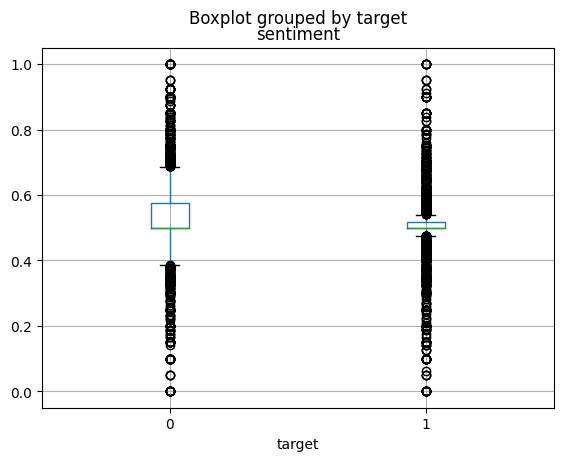

In [11]:
# Graph sentiment on boxplot for category on target
df.boxplot(column='sentiment', by='target')

### Lematizamos las palabras
Esto sirve para devolverlas a su estatus mas simple. Llevarlas al "lexema" puede ser mas facil de evaluar.

In [8]:

# Descargar WordNet si no está disponible
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Aplicar la lematización
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [13]:
# Mostrar las primeras filas del texto limpiado
df['cleaned_text'].head()

,cleaned_text
0,deed reason may allah forgive u
1,forest fire near la ronge sask canada
2,resident asked shelter place notified officer ...
3,people receive evacuation order california
4,got sent photo ruby smoke pours school


#### Análisis de frecuencia

In [9]:
# Unigramas
disaster_words = ' '.join(df[df['target'] == 1]['cleaned_text']).split()
nondisaster_words = ' '.join(df[df['target'] == 0]['cleaned_text']).split()

disaster_freq = Counter(disaster_words)
nondisaster_freq = Counter(nondisaster_words)

In [15]:
disaster_freq.most_common(10)

[('fire', 265),
 ('û_', 172),
 ('amp', 135),
 ('via', 121),
 ('disaster', 113),
 ('year', 112),
 ('suicide', 112),
 ('california', 111),
 ('police', 108),
 ('u', 106)]

In [16]:
nondisaster_freq.most_common(10)

[('like', 255),
 ('amp', 209),
 ('get', 185),
 ('û_', 172),
 ('new', 170),
 ('u', 150),
 ('one', 137),
 ('body', 118),
 ('time', 106),
 ('day', 102)]

### Análisis exploratorio

#### Nube de palabras

Nube de palabras para tweets de desastres


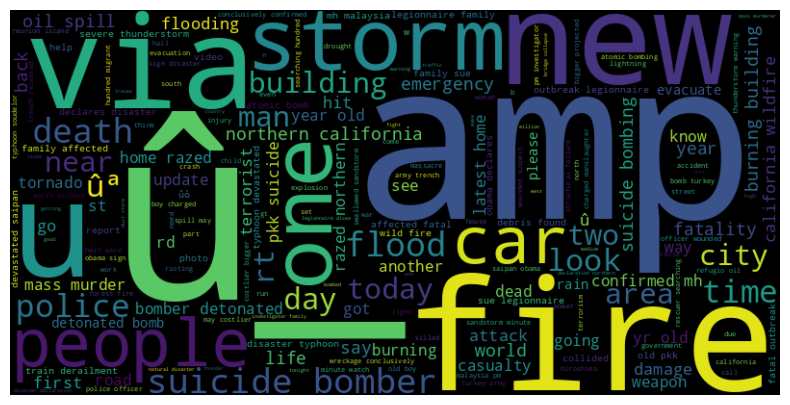

Nube de palabras para tweets no relacionados con desastres


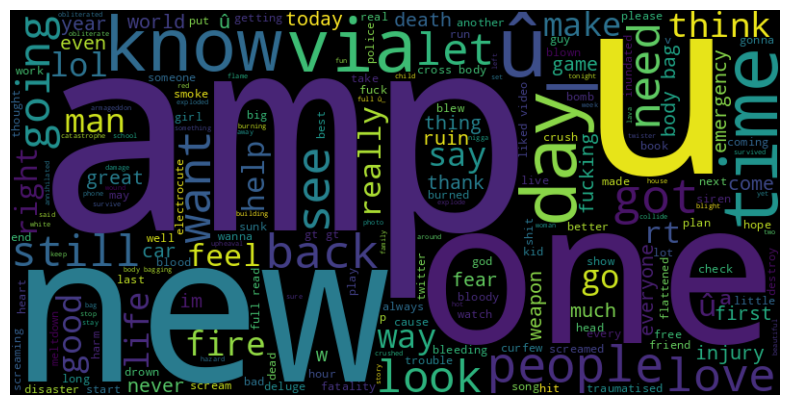

In [17]:
print('Nube de palabras para tweets de desastres')
disaster_wordcloud = WordCloud(width=800, height=400).generate(' '.join(disaster_words))
plt.figure(figsize=(10, 5))
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print('Nube de palabras para tweets no relacionados con desastres')
nondisaster_wordcloud = WordCloud(width=800, height=400).generate(' '.join(nondisaster_words))
plt.figure(figsize=(10, 5))
plt.imshow(nondisaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Histogramas de frecuencia

Histograma de palabras más frecuentes
Plot histogram


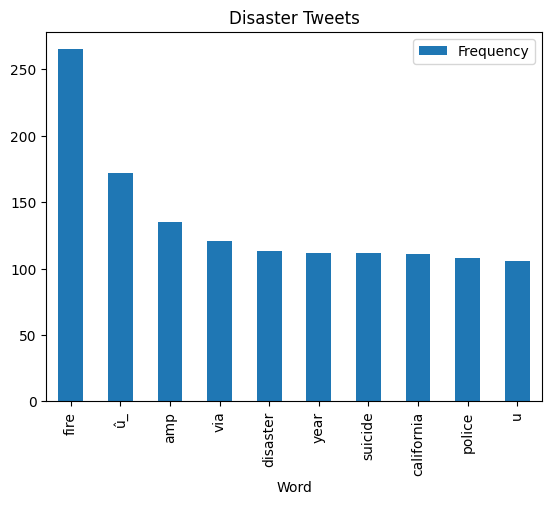

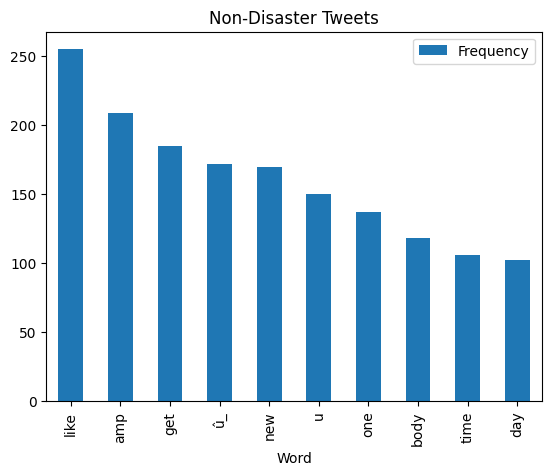

In [18]:
print('Histograma de palabras más frecuentes')
disaster_common_words = disaster_freq.most_common(10)
nondisaster_common_words = nondisaster_freq.most_common(10)

disaster_df = pd.DataFrame(disaster_common_words, columns=['Word', 'Frequency'])
nondisaster_df = pd.DataFrame(nondisaster_common_words, columns=['Word', 'Frequency'])

print('Plot histogram')
disaster_df.plot(kind='bar', x='Word', y='Frequency', title='Disaster Tweets')
nondisaster_df.plot(kind='bar', x='Word', y='Frequency', title='Non-Disaster Tweets')
plt.show()

### Terminamos de hacer ingenieria de caracteristicas.
En este estudio, se llevó a cabo una extensa extracción de características textuales para un modelo de clasificación utilizando diversas técnicas de vectorización. Inicialmente, se aplicaron los métodos de Bag of Words y TF-IDF para transformar el texto limpio en representaciones numéricas, obteniendo matrices dispersas con formas de (7613, 11627) para ambos métodos. Además, se implementó un vectorizador para bi-gramas, ajustado al rango de (2, 2) para reducir la dimensionalidad del modelo y evitar el sobreajuste, lo que resultó en una matriz con forma (7613, 79736). Posteriormente, se concatenaron estas matrices dispersas en una única matriz combinada para capturar la riqueza de características del texto.

Para mejorar la capacidad predictiva del modelo, se incluyeron características adicionales relacionadas con el sentimiento del texto, convertidas a una matriz dispersa y concatenadas con las características textuales. La matriz combinada final, que incluye tanto las características textuales como las sentimentales, se preparó para el entrenamiento del modelo. Los datos fueron divididos en conjuntos de entrenamiento y prueba utilizando train_test_split, con un 30% de los datos reservados para la evaluación del modelo. Este enfoque integral asegura una representación exhaustiva de las características textuales, contribuyendo a una mejor preparación para el aprendizaje automático.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import pandas as pd

# Crear el vectorizador de Bag of Words
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df['cleaned_text'])

# Crear el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Crear el vectorizador para bi-gramas con un rango menor para reducir la dimensionalidad
ngram_vectorizer = CountVectorizer(ngram_range=(2, 2))  # Cambiado de (2, 3) a (2, 2)
X_ngrams = ngram_vectorizer.fit_transform(df['cleaned_text'])

# Verifica las formas de las matrices
print("Bag of Words shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)
print("N-grams shape:", X_ngrams.shape)

# Concatenar las matrices dispersas
X_combined = hstack([X_bow, X_tfidf, X_ngrams], format='csr')

# Obtener nombres de características (se usa solo para debug, no para el DataFrame final)
bow_features = bow_vectorizer.get_feature_names_out()
tfidf_features = tfidf_vectorizer.get_feature_names_out()
ngram_features = ngram_vectorizer.get_feature_names_out()

# Verificar la longitud de cada conjunto de características
print("Number of features from Bag of Words:", len(bow_features))
print("Number of features from TF-IDF:", len(tfidf_features))
print("Number of features from N-grams:", len(ngram_features))


# Convertir características adicionales a una matriz dispersa
additional_features = df['sentiment'].values.reshape(-1, 1)
additional_features_sparse = csr_matrix(additional_features)

# Concatenar características adicionales con las características combinadas
X_combined = hstack([X_combined, additional_features_sparse], format='csr')

# Preparar datos para el modelo
from sklearn.model_selection import train_test_split

X = X_combined
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Bag of Words shape: (7613, 11627)
TF-IDF shape: (7613, 11627)
N-grams shape: (7613, 41017)
Number of features from Bag of Words: 11627
Number of features from TF-IDF: 11627
Number of features from N-grams: 41017


### Modelo preliminar (Regresión logística)

Los resultados del modelo preliminar de regresión logística indican un desempeño bastante equilibrado en la clasificación de tweets relacionados con desastres. La precisión del modelo es del 80%, lo que sugiere que, en general, el modelo realiza una clasificación correcta en la mayoría de los casos. La clase de no desastre (0) muestra una mayor precisión y recall (0.79 y 0.88, respectivamente), reflejando una buena capacidad del modelo para identificar correctamente los tweets no relacionados con desastres. Por otro lado, la clase de desastre (1) tiene una precisión ligeramente superior (0.81) pero un recall más bajo (0.68), lo que indica que, aunque el modelo es efectivo para identificar tweets que efectivamente son desastres, tiene una tendencia a no capturar todos los casos posibles.


              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1318
           1       0.81      0.68      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284



<Axes: >

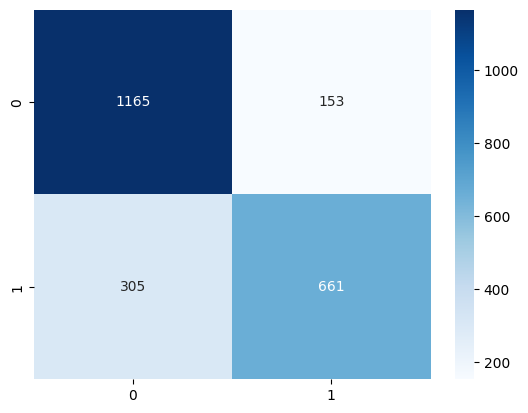

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# Entrenar un modelo preliminar
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matrix of confution
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')



### Modelo Naive Bayes

El modelo de Naive Bayes presenta un desempeño competitivo con una precisión general del 79.2%, que es comparable al rendimiento del modelo de regresión logística previo. En particular, la precisión para la clase de no desastre (0) es del 82%, indicando que el modelo tiene una buena capacidad para identificar tweets no relacionados con desastres. Sin embargo, la clase de desastre (1) muestra una precisión del 76%, que es algo inferior en comparación con el modelo de regresión logística, y un recall de 75%, lo que indica que el modelo podría estar perdiendo algunos casos de desastres en comparación con el modelo anterior.

Accuracy: 0.792031523642732
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1318
           1       0.76      0.75      0.75       966

    accuracy                           0.79      2284
   macro avg       0.79      0.79      0.79      2284
weighted avg       0.79      0.79      0.79      2284



<Axes: >

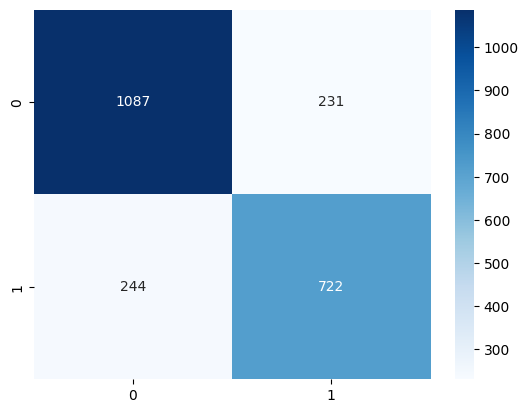

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


### Modelo de vector machine
El modelo LinearSVC alcanza una precisión general del 78.5%, lo que refleja un rendimiento competitivo en la clasificación de tweets sobre desastres. En términos de precisión, el modelo logra un 79% para la clase de no desastre (0), lo que indica una identificación sólida de tweets que no están relacionados con desastres. Sin embargo, la precisión para la clase de desastre (1) es de 77%, lo que sugiere que el modelo podría estar perdiendo algunos casos de desastres comparado con los modelos anteriores.

El recall para la clase de desastre es de 69%, que es menor que el obtenido con los modelos de regresión logística y Naive Bayes, lo que implica que el LinearSVC podría estar clasificando incorrectamente una mayor proporción de tweets de desastres como no desastres. El F1-score para la clase de desastre es de 0.73, reflejando un equilibrio entre precisión y recall para esta clase, pero aún muestra margen de mejora en la detección de tweets de desastres. En general, el LinearSVC ofrece una alternativa válida a los modelos anteriores, pero podría beneficiarse de ajustes adicionales para mejorar su capacidad de detección de desastres.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.7845884413309983
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      1318
           1       0.77      0.69      0.73       966

    accuracy                           0.78      2284
   macro avg       0.78      0.77      0.78      2284
weighted avg       0.78      0.78      0.78      2284



<Axes: >

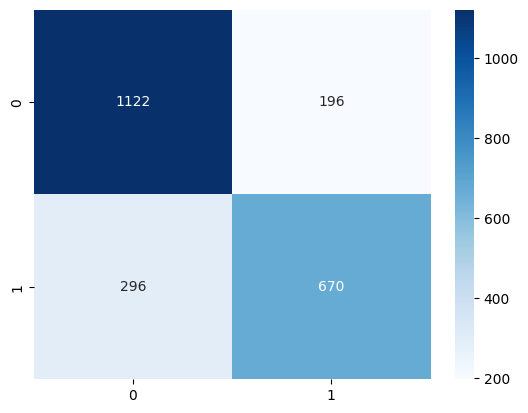

In [22]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

### Modelo Boosting grafient forest
El modelo XGBoost logra una precisión general del 77.3%, que es ligeramente inferior en comparación con los modelos de regresión logística y Naive Bayes, pero todavía competitiva. Este modelo muestra una precisión del 76% para la clase de no desastre (0), sugiriendo que es eficaz en identificar tweets que no están relacionados con desastres. Sin embargo, la precisión para la clase de desastre (1) es del 80%, indicando una capacidad relativamente buena para detectar tweets de desastres en comparación con los otros modelos evaluados.

El recall para la clase de desastre es de 62%, lo que es el más bajo entre los modelos probados, indicando que el XGBoost podría estar pasando por alto un número significativo de tweets que efectivamente describen desastres. Este rendimiento se refleja en un F1-score de 0.70 para la clase de desastre, mostrando un equilibrio limitado entre precisión y recall. En términos de la matriz de confusión, el XGBoost presenta una distribución equilibrada de verdaderos positivos y negativos, pero tiene margen de mejora en la detección de desastres. En resumen, aunque XGBoost proporciona una precisión razonable y una alta precisión para la clase de desastres, su menor recall para esta clase sugiere que podría necesitar ajustes adicionales para mejorar su desempeño en la identificación de tweets sobre desastres.

Sin embargo,  este modelo tiene el mayor potencial de mejora debido a su capacidad para capturar interacciones complejas en los datos. La configuración de hiperparámetros puede significativamente influir en su rendimiento, y el uso de cross-validation puede ayudar a encontrar la mejor configuración para mejorar el recall y el F1-score para la clase de desastres.

Accuracy: 0.7732049036777583
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82      1318
           1       0.80      0.62      0.70       966

    accuracy                           0.77      2284
   macro avg       0.78      0.75      0.76      2284
weighted avg       0.78      0.77      0.77      2284



<Axes: >

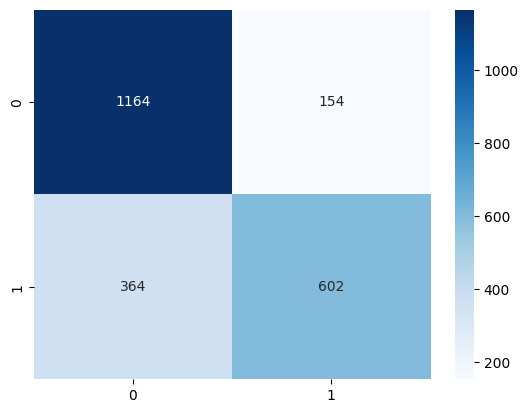

In [23]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters:
 {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'n_estimators': 200}
Best Score: 0.6821173444670525
Test Accuracy: 0.6926444833625219
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.97      0.78      1318
           1       0.87      0.32      0.47       966

    accuracy                           0.69      2284
   macro avg       0.77      0.64      0.63      2284
weighted avg       0.75      0.69      0.65      2284



<Axes: >

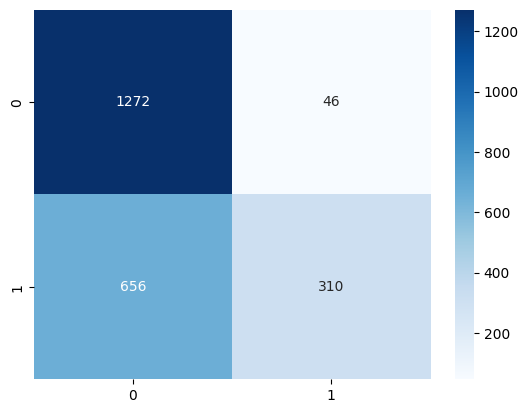

In [25]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# Definir el modelo
model = XGBClassifier()

# Definir los hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01],
    'colsample_bytree': [0.9, 1.0]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='accuracy', # Puedes cambiar el scoring según el objetivo
                           cv=5,  # Número de particiones para cross-validation
                           verbose=1, # Mostrar información de progreso
                           n_jobs=-1) # Usar todos los núcleos disponibles

# Ajustar GridSearchCV
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor score
print("Best Parameters:\n", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Mostrar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Supongamos que X_combined y y están definidos como en el código anterior

# Escalar características (opcional, pero recomendado para redes neuronales)
scaler = StandardScaler(with_mean=False)  # with_mean=False para matrices dispersas
X_scaled = scaler.fit_transform(X_combined)

# Convertir y a formato de clasificación binaria (one-hot encoding)
y_categorical = to_categorical(y)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.3, random_state=42)

# Construir el modelo de red neuronal
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Capa oculta con 64 neuronas
model.add(Dense(32, activation='relu'))  # Capa oculta con 32 neuronas
model.add(Dense(2, activation='softmax'))  # Capa de salida con 2 neuronas (para clasificación binaria)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Opcional: Graficar la evolución de la precisión y pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
 24/134 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.5158 - loss: 0.8371

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

# Supongamos que X_combined y y están definidos como en el código anterior

# Escalar características
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_combined)

# Convertir y a formato de clasificación binaria
y_categorical = to_categorical(y)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.3, random_state=42)

# Construir el modelo de red neuronal
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))  # Capa oculta con menos neuronas
model.add(Dropout(0.5))  # Dropout con probabilidad del 50%
model.add(BatchNormalization())  # Normalización por lotes
model.add(Dense(8, activation='relu', kernel_regularizer='l2'))  # Capa oculta con menos neuronas
model.add(Dropout(0.5))  # Dropout con probabilidad del 50%
model.add(BatchNormalization())  # Normalización por lotes
model.add(Dense(2, activation='softmax'))  # Capa de salida con 2 neuronas (para clasificación binaria)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar Early Stopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Graficar la evolución de la precisión y pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


In [ ]:
# Use the model to show a confution matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Luego de realizar los modelos previos, determinamos que el mejor modelo para este caso en especifico es el modelo naive bayes.